## TSNE visualization of embeddings from all models trained on UniRef90 dataset for multiclass classification

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..']

In [2]:
from prediction.models.nlp import transformer, rnn, lstm, fnn
from src.utils import utils, nn_utils

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [3]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635"
train_file_names = ["uniref90_final.csv_tr0.8_train.csv"]
test_file_names = ["uniref90_final.csv_tr0.8_test.csv"]

label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1115,
    "pad_sequence_val": 0,
    "truncate": True
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1115,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 9,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [4]:
def load_dataset(input_dir, input_file_names, sequence_settings):
    df = utils.read_dataset(input_dir, input_file_names, cols=[sequence_settings["sequence_col"], label_settings["label_col"]])
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def load_dataset_with_df(df, sequence_settings):
    df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)

#### UniRef90 Datasets
19k
all viruses, all hosts, all proteins, without duplicates and single hosts

In [5]:
index_label_map, train_dataset_loader = load_dataset(input_dir, train_file_names, train_sequence_settings)
print_dataset_loader(train_dataset_loader)

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_train.csv, size = (15274, 2)
Size of input dataset = (15274, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 3 0 6 5 1 2 8 7]


KeyError: 'feature_type'

### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [6]:
def visualize_dataset(rep_df):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    X_emb["label"] = rep_df["label"].values
    X_emb["label"] = X_emb["label"].map(index_label_map)
    X_emb = X_emb[X_emb["label"] != "Others"]
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    

### Model: FNN
#### FNN - MSL_1114 - l_10 - d_512
#### Manual Seed = 0

In [7]:
def compute_dataset_representations_fnn(nlp_model, dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.fnn_emb
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

In [8]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230709/host_multi_baseline_focal/fnn-l_10_itr4.pth"
model["depth"] = 10
nlp_model = fnn.get_fnn_model(model)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())

FNN_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (linear_ip): Linear(in_features=512, out_features=1024, bias=True)
  (linear_hidden): Linear(in_features=1024, out_features=1024, bias=True)
  (linear_hidden_n): ModuleList(
    (0-9): 10 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (linear_op): Linear(in_features=1024, out_features=9, bias=True)
)
Number of parameters =  12093961


(15274, 1025)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
          1015,    1016,    1017,    1018,    1019,    1020,    1021,    1022,
          1023, 'label'],
      dtype='object', length=1025)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 6.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sampl

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.687191
[t-SNE] KL divergence after 1000 iterations: -0.032411
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.008s...
[t-SNE] Computed neighbors for 15274 samples in 6.983s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.687191
[t-SNE] KL divergence after 1000 iterations: -0.032411
(15274, 2)


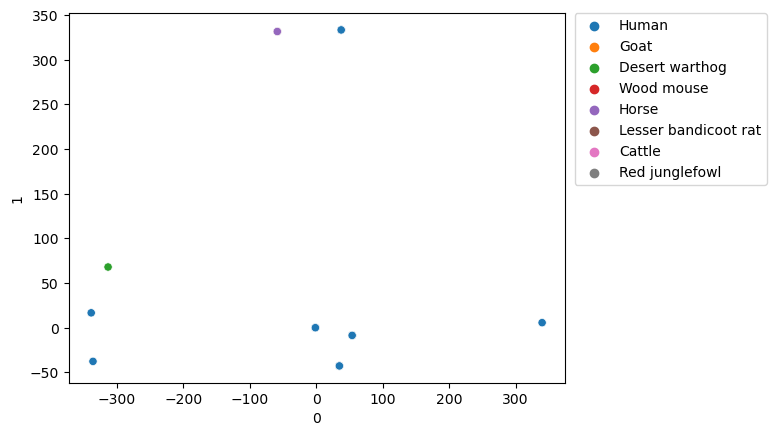

In [9]:
train_rep_df = compute_dataset_representations_fnn(nlp_model, train_dataset_loader)
visualize_dataset(train_rep_df)

### Model: RNN
#### RNN - MSL_1114 - l_6 - d_512
#### Manual Seed = 0

In [7]:
def compute_dataset_representations_rnn(nlp_model, dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.rnn_emb
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

In [8]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230709/host_multi_baseline_focal/rnn-l_6_itr4.pth"

nlp_model = rnn.get_rnn_model(model)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())

RNN_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (rnn): RNN(512, 1024, num_layers=6, batch_first=True)
  (linear): Linear(in_features=1024, out_features=9, bias=True)
)
Number of parameters =  12093961


(15274, 1025)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
          1015,    1016,    1017,    1018,    1019,    1020,    1021,    1022,
          1023, 'label'],
      dtype='object', length=1025)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 9.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sampl

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.761826
[t-SNE] KL divergence after 1000 iterations: 0.895115
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.007s...
[t-SNE] Computed neighbors for 15274 samples in 8.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.762512
[t-SNE] KL divergence after 1000 iterations: 0.895301
(15274, 2)


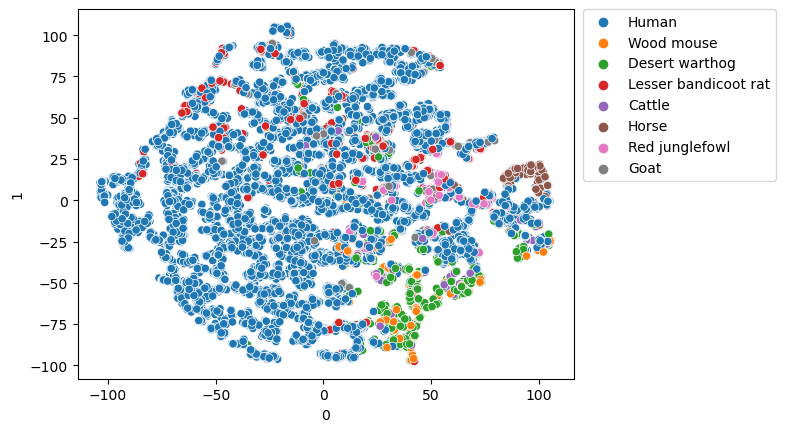

In [9]:
train_rep_df = compute_dataset_representations_rnn(nlp_model, train_dataset_loader)
visualize_dataset(train_rep_df)

### Model: LSTM
#### LSTM - MSL_1114 - l_2 - d_512
#### Manual Seed = 0

In [12]:
def compute_dataset_representations_lstm(nlp_model, dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.lstm_emb
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

In [14]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230709/host_multi_baseline_focal/lstm-l_2_itr4.pth"
model["depth"] = 2
nlp_model = lstm.get_lstm_model(model)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())

LSTM_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1024, out_features=9, bias=True)
)
Number of parameters =  14719497


(15274, 1025)
Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
          1015,    1016,    1017,    1018,    1019,    1020,    1021,    1022,
          1023, 'label'],
      dtype='object', length=1025)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.008s...
[t-SNE] Computed neighbors for 15274 samples in 8.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sampl

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.293129
[t-SNE] KL divergence after 1000 iterations: 0.931579
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.008s...
[t-SNE] Computed neighbors for 15274 samples in 8.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.294189
[t-SNE] KL divergence after 1000 iterations: 0.933139
(15274, 2)


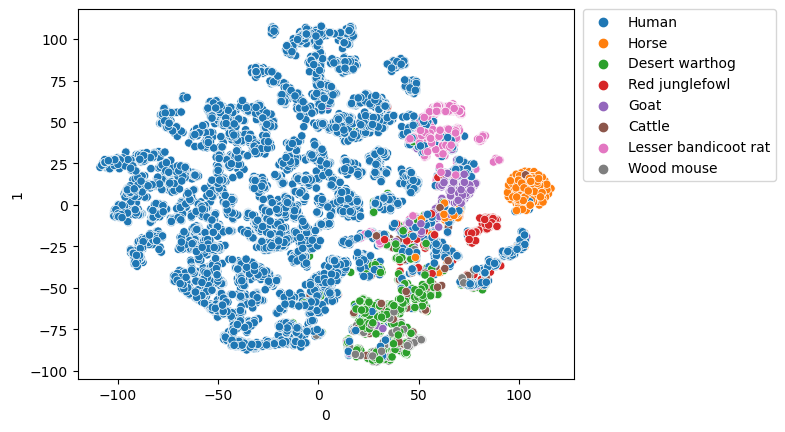

In [15]:
train_rep_df = compute_dataset_representations_lstm(nlp_model, train_dataset_loader)
visualize_dataset(train_rep_df)

### Model: Transformer
#### TF - PosEmb_SINCOS - MSL_1114 - d_512
#### Manual Seed = 0

In [28]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230705/host_multi_msl1114_baseline/transformer_itr0.pth"
model["depth"] = 6
nlp_model = transformer.get_transformer_model(model)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())


Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=9, b

In [29]:
def compute_dataset_representations_tf(nlp_model, dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df
train_rep_df = compute_dataset_representations_tf(nlp_model, train_dataset_loader)


(15274, 513)


Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.009s...
[t-SNE] Computed neighbors for 15274 samples in 8.782s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.254349
[t-SNE] KL divergence after 1000 iterations: 1.056278
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.008s...
[t-SNE] Computed neighbors for 15274 samples in 8.969s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.255051
[t-SNE] KL divergence after 1000 iterations: 1.054107
(15274, 2)


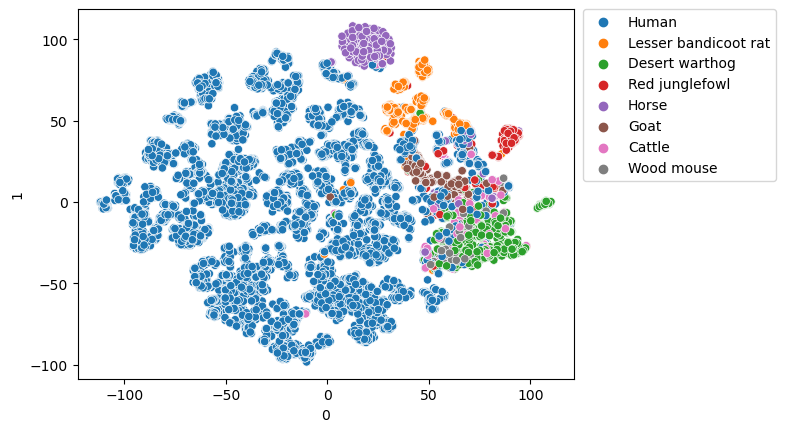

In [21]:
visualize_dataset(train_rep_df)